# Image Processing

In [1]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split
import random
import matplotlib.pyplot as plt
import numpy as np
from torch import optim
from torch.optim import lr_scheduler
import torchvision.models as models
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

# ----------------------------------------------------------------------------------------------
# Augmentation
# Define data augmentation transforms
transform = transforms.Compose([
    # transforms.RandomHorizontalFlip(),
    transforms.Resize((224,224)),
    # transforms.RandomVerticalFlip(),
    # transforms.RandomRotation(30),  # Randomly rotate the image up to 30 degrees
    # transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),  # Adjust color
    # transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),  # Random affine transformation
    # transforms.RandomPerspective(),  # Random perspective transformation
    # transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),  # Random resized crop
    transforms.ToTensor(),  # Convert the image to a PyTorch tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalize the image to RGB
])

dataset = ImageFolder(root='/local/data1/honzh073/data/FracImage', transform=transform)

# ----------------------------------------------------------------------------------------------
# Random seed
seed = 1
random.seed(seed)
torch.manual_seed(seed)

# Split dataset into 80% train, 10% validation, and 10% test
total_size = len(dataset)
train_size = int(0.8 * total_size)
validation_size = int(0.1 * total_size)
test_size = total_size - train_size - validation_size

train_dataset, validation_dataset, test_dataset = random_split(
    dataset, [train_size, validation_size, test_size], generator=torch.Generator().manual_seed(seed)
)

# DataLoader for training, validation, and testing
batch_size = 64

# Move data loaders to GPU if available
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)
validation_loader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=False, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, pin_memory=True)

# ----------------------------------------------------------------------------------------------
# Check if CUDA is available
if torch.cuda.is_available():
    print("CUDA!")
    device = torch.device("cuda:1")  # Use GPU 0
else:
    print("CUDA is not available.")
    device = torch.device("cpu")
# ----------------------------------------------------------------------------------------------
print('done!')


CUDA!
done!


# Plot 8 bit Images

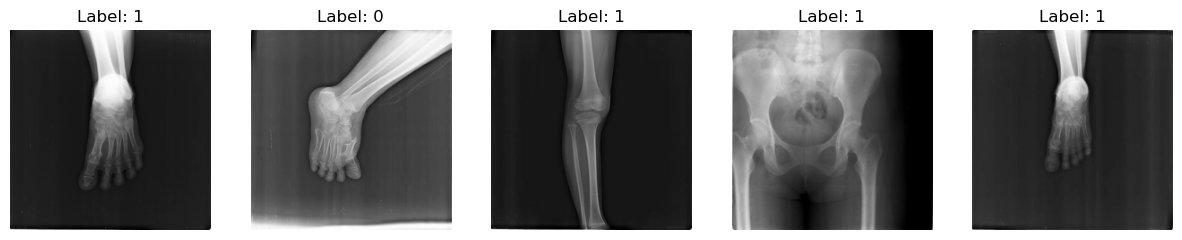

In [2]:
# ---------------------------------------------------------------------------------
# Get some random indices from the training dataset
random_indices = np.random.choice(len(validation_dataset), 5, replace=False)

# Plot images (transformed)
plt.figure(figsize=(15, 5))
for i, idx in enumerate(random_indices):
    image, label = train_dataset[idx]
    plt.subplot(1, 5, i + 1)
    plt.title(f"Label: {label}")
    # plt.imshow(image[0])  # 3-channel (RGB)
    plt.imshow(image[0], cmap='gray')  #single-channel (grayscale)
    plt.axis('off')
plt.show()


# Class weights of Training Dataset

In [3]:
# ---------------------------------------------------------------------------------
# aff and nff numbers in training dataset
train_aff_count = sum(1 for _, label in train_dataset if label == 0)  # 0 frac
train_nff_count = sum(1 for _, label in train_dataset if label == 1)  # 1 no_frac

# # aff and nff numbers in test dataset
# valid_aff_count = sum(1 for _, label in validation_dataset if label == 0)
# valid_nff_count = sum(1 for _, label in validation_dataset if label == 1)

# # aff and nff numbers in test dataset
# test_aff_count = sum(1 for _, label in test_dataset if label == 0)
# test_nff_count = sum(1 for _, label in test_dataset if label == 1)

# print(f"train aff number: {train_aff_count}")
# print(f"train nff number: {train_nff_count}")
# print(f"val aff number: {valid_aff_count}")
# print(f"val nff number: {valid_nff_count}")
# print(f"test aff number: {test_aff_count}")
# print(f"test nff number: {test_nff_count}")

# # ---------------------------------------------------------------------------------
# # Calculate class weights
n_aff_train = train_aff_count
n_nff_train = train_nff_count

class_weight_aff = 1 / (2 * (n_aff_train / (n_aff_train + n_nff_train)))
class_weight_nff = 1 / (2 * (n_nff_train / (n_aff_train + n_nff_train)))

print(f"Class Weight for AFF (0): {class_weight_aff:.4f}")
print(f"Class Weight for NFF (1): {class_weight_nff:.4f}")
class_weights = [class_weight_aff, class_weight_nff]
print(class_weights)


Class Weight for AFF (0): 2.8010
Class Weight for NFF (1): 0.6086
[2.8010291595197256, 0.6086470368989937]


# ResNet101
# Train on Training and Validation Dataset
# Test Performance

Epoch 1/100, Train Loss: 0.3453, Validation Loss: 0.3852, Train Acc: 75.72%, Validation Acc: 90.20%
Epoch 2/100, Train Loss: 0.3431, Validation Loss: 0.4909, Train Acc: 92.28%, Validation Acc: 82.11%
Epoch 3/100, Train Loss: 0.2514, Validation Loss: 0.5273, Train Acc: 96.66%, Validation Acc: 82.84%
Epoch 4/100, Train Loss: 1.8985, Validation Loss: 1.6557, Train Acc: 98.84%, Validation Acc: 58.82%
Epoch 5/100, Train Loss: 1.1909, Validation Loss: 0.8418, Train Acc: 98.96%, Validation Acc: 90.93%
Epoch 6/100, Train Loss: 0.4711, Validation Loss: 0.6282, Train Acc: 99.45%, Validation Acc: 84.80%
Epoch 7/100, Train Loss: 1.0612, Validation Loss: 0.6706, Train Acc: 99.08%, Validation Acc: 88.97%
Epoch 8/100, Train Loss: 1.0921, Validation Loss: 0.8811, Train Acc: 99.51%, Validation Acc: 90.69%
Epoch 9/100, Train Loss: 1.3154, Validation Loss: 0.8013, Train Acc: 99.69%, Validation Acc: 93.63%
Epoch 10/100, Train Loss: 1.2193, Validation Loss: 0.9711, Train Acc: 99.82%, Validation Acc: 91.42%

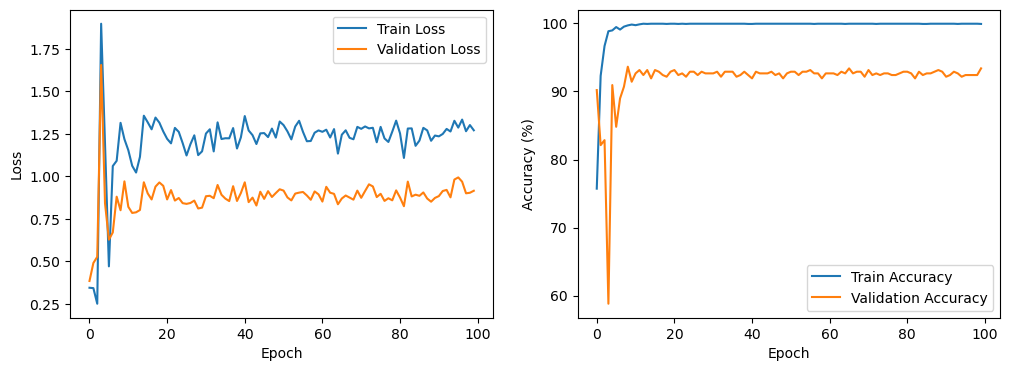

Test Loss: 1.1844, Test Acc: 90.71%


In [4]:
from torchvision.models import resnet101, ResNet101_Weights

# decrease learning rate by rounds, become 0.00000001 after 5 rounds
lr = 0.0001 # 0.01
step_size = 10
gamma = 0.1

# Move class weights to the selected device
class_weights = class_weights
class_weights = torch.Tensor(class_weights).to(device)

torch.hub.set_dir('/local/data1/honzh073/download/TORCH_PRETRAINED')

# ResNet152
model = models.resnet101(weights=ResNet101_Weights.DEFAULT)
model = model.to(device)

# Update the output layer
model.fc = nn.Linear(2048, 2)  # output layer classes number = dataset classes number
model = model.to(device)

# Loss function
criterion = nn.CrossEntropyLoss(weight=class_weights)
criterion = criterion.to(device)

optimizer = optim.RMSprop(model.parameters(), lr=lr)
scheduler = lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

# Training and validation
train_losses = []
validation_losses = []
train_accuracies = []
validation_accuracies = []

num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    correct_train = 0
    total_train = 0
    
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()
    
    train_accuracy = 100 * correct_train / total_train
    
    model.eval()
    correct_validation = 0
    total_validation = 0
    validation_loss = 0
    
    with torch.no_grad():
        for images, labels in validation_loader:
            images = images.to(device)
            labels = labels.to(device)
            
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            _, predicted = torch.max(outputs.data, 1)
            total_validation += labels.size(0)
            correct_validation += (predicted == labels).sum().item()
            validation_loss += loss.item()
    
    validation_accuracy = 100 * correct_validation / total_validation
    validation_loss /= len(validation_loader)
    
    train_losses.append(loss.item())
    validation_losses.append(validation_loss)
    train_accuracies.append(train_accuracy)
    validation_accuracies.append(validation_accuracy)
    
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {loss.item():.4f}, Validation Loss: {validation_loss:.4f}, Train Acc: {train_accuracy:.2f}%, Validation Acc: {validation_accuracy:.2f}%")
    
    scheduler.step()  # Step the learning rate scheduler

# Plot loss and accuracy
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(validation_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(validation_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.show()

# Test the model on the test dataset
model.eval()
correct_test = 0
total_test = 0
test_loss = 0

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        _, predicted = torch.max(outputs.data, 1)
        total_test += labels.size(0)
        correct_test += (predicted == labels).sum().item()
        test_loss += loss.item()

test_accuracy = 100 * correct_test / total_test
test_loss /= len(test_loader)

print(f"Test Loss: {test_loss:.4f}, Test Acc: {test_accuracy:.2f}%")


# Save model

In [5]:
# Save the trained model
torch.save(model.state_dict(), '/local/data1/honzh073/saved_model/fracatlas_101.pth')


# Clean GPU memory

In [6]:
torch.cuda.empty_cache()
